In [1]:
import numpy as np
import os
import torch
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR
import torch.optim as optim
#from torchvision import models
#from torchsummary import summary
import matplotlib.pyplot as plt

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    #random.seed(seed)
    torch.backends.cudnn.deterministic = True

def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

/DATA/vin/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EEGNet(nn.Module):
    def __init__(self, activation='relu', dropout=0.25):
        super(EEGNet, self).__init__()
        self.act_type = activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU()
        else:
            self.activation = nn.ELU(alpha=1.0)

        self.conv2d = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv2d = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            self.activation,
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=dropout)
        )
        self.separableConv2d = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            self.activation,
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout)
        )
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
    def info(self):
        print(f"training EEGNet with {self.act_type}")
        
    def forward(self, x):
        
        out = self.conv2d(x)
        out = self.depthwiseConv2d(out)
        out = self.separableConv2d(out)
        out = self.classify(out)
        return out

In [3]:
class DeepConvNet(nn.Module):
    def __init__(self, activation='relu'):
        super(DeepConvNet, self).__init__()
        self.act_type = activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU()
        else:
            self.activation = nn.ELU(alpha=1.0)

        self.layer0 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1), padding=(0, 0), bias=False),
            nn.Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(25),
            self.activation,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5))

        self.layer1 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(50),
            self.activation,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5))

        self.layer2 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(100),
            self.activation,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5))

        self.layer3 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), stride=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(200),
            self.activation,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5))

        self.layer4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=43*200, out_features=2, bias=True))
    def info(self):
        print(f"training DeepConvNet with {self.act_type}")
    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [4]:
def train(model, device, train_loader, optimizer, criterion, learning_rate, epoch, gamma, log_period, test_loader, train_record, test_record):
    
    opt = optimizer(model.parameters(), lr=learning_rate)
    scheduler = ExponentialLR(opt, gamma=gamma)

    for i in range(epoch):
        loss_sum = 0
        correct = 0
        model.train()
        for data,target in train_loader:
            data, target = data.to(device), target.to(device)
            
            opt.zero_grad()
            out = model.forward(data)
            loss = criterion(out,target)
            
            out = torch.argmax(out, dim=1)
            correct += (out==target).sum().cpu().item()
            
            loss.backward()
            opt.step()
            
            loss_sum += loss.cpu().item()
        #scheduler.step()
        train_acc = 100. * correct / len(train_loader.dataset)
        test_acc = test(model,device,test_loader)
        train_record.append(train_acc)
        test_record.append(test_acc)
        if((i+1) % log_period == 0):
            print(f"Train epoch: {i+1:<5}loss: {(loss_sum/(log_period*len(train_loader.dataset))):<25}\
            train acc: {train_acc:<25}test acc: {test_acc}") 

def test(model, device, test_loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            out = model.forward(data)
            out = torch.argmax(out, dim=1)
            correct += (out==target).sum().cpu().item()
    acc = 100. * correct / len(test_loader.dataset)
    return acc

In [5]:
def plot(train_record,test_record,act_funcs,model='EEG'):
    offset = 0
    if(model=="EEG"):
        plt.title('Activation function comparision(EEGNet)')
    else:
        offset = 3
        plt.title('Activation function comparision(DeepConvNet)')
    episodes = list(range(1,len(train_records[0])+1))

        
    for i,a in enumerate(act_funcs):
        plt.plot(episodes,train_record[i+offset],label=model+"_"+a)
        plt.plot(episodes,test_record[i+offset],label=model+"_"+a)
    
    plt.xlabel('Episodes')
    plt.ylabel('Accuracy(%)')
    plt.legend()
    plt.show()

In [6]:
setup_seed(87)
train_x,train_y,test_x,test_y = read_bci_data()

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 32
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': len(train_y)}
if use_cuda:
    print("Use GPU for training...")
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
else:
    print("Use CPU to training...")


train_dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float32),torch.tensor(train_y, dtype=torch.int64))
test_dataset = TensorDataset(torch.tensor(test_x, dtype=torch.float32), torch.tensor(test_y, dtype=torch.int64))
train_loader = DataLoader(train_dataset, **train_kwargs)
test_loader = DataLoader(test_dataset, **test_kwargs)
    
train_records = [[],[],[],[],[],[]]
test_records = [[],[],[],[],[],[]]

act_funcs = ['lrelu','relu','elu']

for i,a in enumerate(act_funcs):
    model = EEGNet(activation=a).to(device)
    model.info()
    train(model=model, 
          device=device, 
          train_loader=train_loader, 
          optimizer=optim.RAdam, 
          criterion=nn.CrossEntropyLoss(),
          learning_rate=1e-3, 
          epoch=300, 
          gamma=1.0, 
          log_period=1000,
          test_loader=test_loader,
          train_record=train_records[i],
          test_record=test_records[i])
    torch.save(model.state_dict(),os.path.join("models","EEG_"+a+".cpt"))
    print(f"Final test accuracy: {test_records[i][-1]}")
    print(" ")

for i,a in enumerate(act_funcs):
    model = DeepConvNet(activation=a).to(device)
    model.info()
    train(model=model, 
          device=device, 
          train_loader=train_loader, 
          optimizer=optim.RAdam, 
          criterion=nn.CrossEntropyLoss(),
          learning_rate=1e-3, 
          epoch=300, 
          gamma=1.0, 
          log_period=1000,
          test_loader=test_loader,
          train_record=train_records[i+3],
          test_record=test_records[i+3])
    torch.save(model.state_dict(),os.path.join("models","DeepConv_"+a+".cpt"))
    print(f"Final test accuracy: {test_records[i+3][-1]}")
    print(" ")

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
Use GPU for training...
training EEGNet with lrelu
Final test accuracy: 87.03703703703704
 
training EEGNet with relu
Final test accuracy: 86.66666666666667
 
training EEGNet with elu
Final test accuracy: 82.4074074074074
 
training DeepConvNet with lrelu
Final test accuracy: 81.29629629629629
 
training DeepConvNet with relu
Final test accuracy: 81.01851851851852
 
training DeepConvNet with elu
Final test accuracy: 80.64814814814815
 


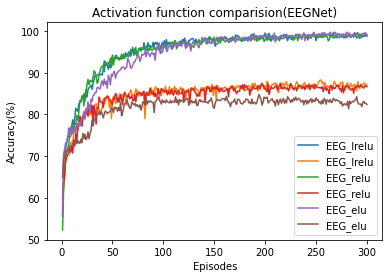

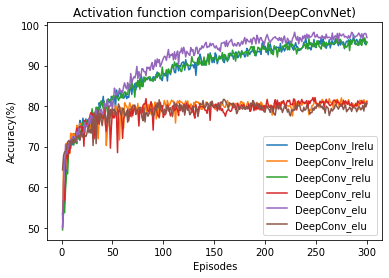

In [7]:
plot(train_records,test_records,act_funcs)
plot(train_records,test_records,act_funcs,'DeepConv')